Experiment with computer vision model

In [1]:
%load_ext autoreload
%autoreload 2
from dataclasses import MISSING, asdict, dataclass, field, fields
from typing import List

from multiobjective_opt.neural_net.models.cifar_parametrized import ResNet


@dataclass
class ResNetParams:
    num_blocks: List = field(
        default_factory=lambda: [2, 2, 2, 2]
    )  # Количество блоков в каждом слое
    num_filters: int = 32  # Количество фильтров в начальном слое
    use_batchnorm: bool = False  # Использовать BatchNorm
    use_dropout: bool = False  # Использовать Dropout
    dropout_prob: float = 0.5  # Вероятность дропаут

In [77]:
a = ResNetParams()
model = ResNet(**asdict(a))
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

2792810


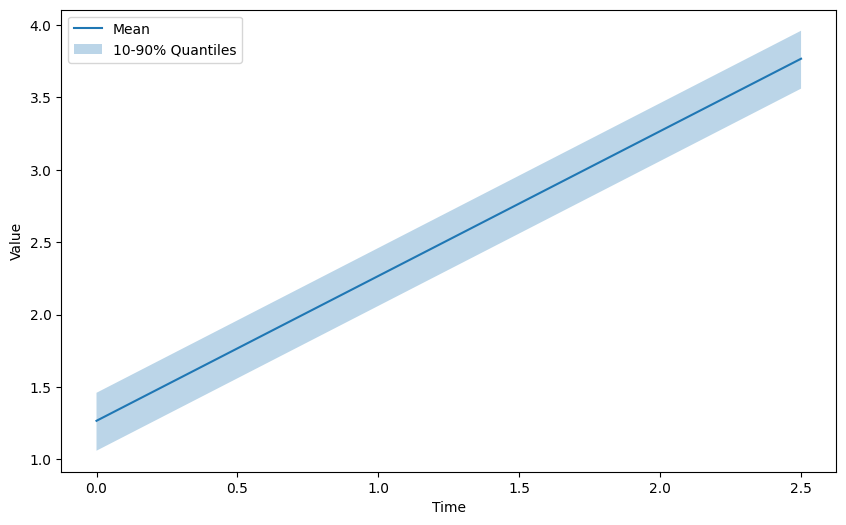

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# Пример данных: список наблюдений (x_i, t_i)
observations = [
    (np.array([1, 2, 3]), np.array([0, 1, 2])),  # Наблюдение 1
    (np.array([2, 3, 4]), np.array([0.5, 1.5, 2.5])),  # Наблюдение 2
    (np.array([1.5, 2.5, 3.5]), np.array([0.2, 1.2, 2.2]))  # Наблюдение 3
]

def interpolated_graphs(values, times):
    """
    values [n_runs x n_arms x n_observations]
    times [n_runs x n_arms x n_observations]
    """
# Шаг 1: Создать общую временную сетку
min_time = min(min(t) for _, t in observations)
max_time = max(max(t) for _, t in observations)
time_grid = np.linspace(min_time, max_time, num=100)  # 100 точек на сетке

# Шаг 2: Интерполировать данные на общей сетке
interpolated_data = []
for x, t in observations:
    interp_func = interp1d(t, x, kind='linear', fill_value="extrapolate")
    interpolated_data.append(interp_func(time_grid))

# Шаг 3: Агрегировать данные
interpolated_data = np.array(interpolated_data)  # Преобразовать в массив NumPy

# Среднее значение
mean_values = np.mean(interpolated_data, axis=0)

# Квантили (например, 0.1 и 0.9)
quantile_10 = np.quantile(interpolated_data, q=0.1, axis=0)
quantile_90 = np.quantile(interpolated_data, q=0.9, axis=0)

# Результаты
results = pd.DataFrame({
    "time": time_grid,
    "mean": mean_values,
    "quantile_10": quantile_10,
    "quantile_90": quantile_90
})


In [2]:
data

[['MobileNetV2', 5, 0.1, 2.532846055984497, 10.0],
 ['ShuffleNetV2', 5, 0.1, 3.2261962982177734, 10.0],
 ['CifarResNet', 5, 0.1736, 2.9982690547943114, 10.0],
 ['MobileNetV2', 5, 0.1, 3.0422104480743406, 10.0],
 43.958447217941284]

In [10]:
import pickle
from tabulate import tabulate
with open("../exp_results/cv/cifar10_different.pkl", "rb") as f:
    data = pickle.load(f)
    data =data[:-1]

headers = ["Model name", "Train loss", "Model Accuracy", "Model loss", "runtime", "epochs"]
print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="heavy_outline"))
# print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="latex"))

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model name   ┃   Train loss ┃   Model Accuracy ┃   Model loss ┃   runtime ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ MobileNetV2  ┃           26 ┃            0.533 ┃        1.283 ┃     2.193 ┃
┃ ShuffleNetV2 ┃           26 ┃            0.545 ┃        1.263 ┃     2.193 ┃
┃ CifarResNet  ┃           23 ┃            0.506 ┃        1.413 ┃     2.331 ┃
┃ MobileNetV2  ┃           25 ┃            0.534 ┃        1.396 ┃     2.236 ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━┛


In [11]:
import json

with open("../exp_results/cv/cifar10_different.json", "r") as f:
    bounds = json.load(f)

def get_times():
    model_time = {i: 0. for i in range(9)}
    model_time[0] = bounds[0][1]
    for i in range(1, len(bounds)):
        model_time[bounds[i][0]] += bounds[i][1] - bounds[i-1][1]
    return model_time

times_online = get_times()

import pickle
from tabulate import tabulate
with open("../exp_results/cv/cifar10_different.pkl", "rb") as f:
    data_mab = pickle.load(f)
runtime = data_mab[-1]
data_mab = data_mab[:-1]
for i, elem in enumerate(data_mab):
    elem[0] = f"{elem[0]}_{i}"
    del elem[-1]
    elem.append(times_online[i])
headers = [
        "Model name",
        "model pulls",
        "Model Accuracy",
        "Model loss",
        # "Confidence interval",
        "Runtime"
    ]

print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="heavy_outline"))
# print(tabulate(data_mab, headers=headers, floatfmt=".3f", tablefmt="latex"))
print(runtime)

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Model name   ┃   model pulls ┃   Model Accuracy ┃   Model loss ┃   Runtime ┃
┣━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━┫
┃ MobileNetV2  ┃            26 ┃            0.533 ┃        1.283 ┃     2.193 ┃
┃ ShuffleNetV2 ┃            26 ┃            0.545 ┃        1.263 ┃     2.193 ┃
┃ CifarResNet  ┃            23 ┃            0.506 ┃        1.413 ┃     2.331 ┃
┃ MobileNetV2  ┃            25 ┃            0.534 ┃        1.396 ┃     2.236 ┃
┗━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━┛
279.12013483047485


In [95]:
# в одну табличку
data_all = []
for full_tr, online_tr in zip(data, data_mab):
    elem = [full_tr[0], online_tr[1], online_tr[2], online_tr[4], full_tr[2], full_tr[4]]
    data_all.append(elem)
headers = [
        "Model name",
        "model pulls",
        "Online Accuracy",
        "Online Runtime",
        "Full Accuracy",
        "Full Runtime"
    ]

# print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="heavy_outline"))
print(tabulate(data_all, headers=headers, floatfmt=".3f", tablefmt="latex"))
print(runtime)

\begin{tabular}{lrrrrr}
\hline
 Model name   &   model pulls &   Online Accuracy &   Online Runtime &   Full Accuracy &   Full Runtime \\
\hline
 ResNet\_0     &            41 &             0.718 &          316.615 &           0.724 &       1004.294 \\
 ResNet\_1     &            42 &             0.727 &          154.768 &           0.756 &        946.506 \\
 ResNet\_2     &            49 &             0.725 &          194.925 &           0.760 &        276.188 \\
 ResNet\_3     &           108 &             0.819 &         1069.787 &           0.873 &        740.204 \\
 ResNet\_4     &           113 &             0.842 &          486.925 &           0.858 &        579.696 \\
 ResNet\_5     &           169 &             0.841 &          768.587 &           0.851 &        844.796 \\
 ResNet\_6     &           178 &             0.830 &         1758.527 &           0.871 &        903.429 \\
 ResNet\_7     &           154 &             0.808 &          662.013 &           0.826 &        28

In [ ]:
import numpy as np
def get_history(field_name):
    b = [bb[2][field_name] for bb in bounds[:9]]
    bounds_history = np.zeros((len(bounds), 9))
    bounds_history[0] = b
    for i, hist_el in enumerate(bounds[9:], 1):
        arm = hist_el[0]
        ucb = hist_el[2][field_name]
        b[arm] = ucb
        bounds_history[i] = b
    bounds_history = bounds_history[:-9].T
    return bounds_history

loss_hist = get_history("loss")
bound_hist = get_history("ucb_val")

import matplotlib.pyplot as plt

colors = ["r", "g", "black", 'y', "navy", 'lightgreen', "brown", "blue", "purple"]
for i, (loss, bound, color) in enumerate(zip(loss_hist, bound_hist, colors)):
    plt.plot(loss, label = f"ResNet-{i}", color = color)
    x = np.arange(len(loss))
    plt.fill_between(x, bound, loss,color=color,
                    alpha=0.1,)
plt.ylim((-2, 3.5))
plt.xlabel(r"$\#$ iterations.")
plt.ylabel("Loss")
plt.legend()

### mlflow example


In [2]:
import mlflow
import os
print(os.getcwd())
if os.getcwd().endswith("/multiobjective_opt/notebooks"):
    os.chdir("..")

/home/xxam_xam/my_files/multiobjective_opt/notebooks


In [3]:
runs = mlflow.get_experiment_by_name("cifar10_simple_min_long_fixed")
runs = mlflow.search_runs([runs.experiment_id])

In [4]:
from tabulate import tabulate
import json

full_train_pos = runs["tags.mlflow.runName"].apply(lambda x: x.startswith("full_train"))
run_id = runs[full_train_pos]["run_id"].values[0]
artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="run_results_table.json")

with open(artifact_path, "r") as f:
    f = json.load(f)

print(tabulate(list(f.values())[1], headers=list(f.values())[0], floatfmt=".3f", tablefmt="heavy_outline"))

IndexError: index 0 is out of bounds for axis 0 with size 0

нарисуем

In [5]:

exps = runs[runs['tags.mlflow.runName'].apply( lambda x: x.startswith("mab_train"))]
for run_id in exps['run_id']:
    artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="run_results_table.json")

    with open(artifact_path, "r") as f:
        tab = json.load(f)

    # print(tabulate(list(tab.values())[1], headers=list(tab.values())[0], floatfmt=".3f", tablefmt="heavy_outline"))

In [6]:
durations = []
for run_id in exps['run_id']:
    artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="ucb_values.json")
    artifact_path
    with open(artifact_path, "r") as f:
            rf = json.load(f)
    durations.append(rf[-1]['duration'])

    # for i in range(7):
    #     rf[i] = {"arm": rf[i][0],"duration": rf[i][1], "pull_res": rf[i][2]}

In [7]:
durations = np.array(durations)
durations /= 60
np.mean(durations), np.std(durations)

NameError: name 'np' is not defined

In [8]:
def parse_values(f, n_arms = 7):
    def get_placeholder_for_val():
        return np.zeros((len(f) - n_arms,n_arms))
    duration = np.zeros(n_arms, float)
    key_res = {key: get_placeholder_for_val() for key in f[0]["pull_res"].keys()}
    for i, elem in enumerate(f[:n_arms]):
        # инициализируем значения
        arm = elem['arm']
        duration[arm] = elem["duration"] - (f[i-1]["duration"] if i > 0 else 0)
        for k, v in elem["pull_res"].items():
            key_res[k][0][arm] = v
    
    # заполнение
    for i, elem in enumerate(f[n_arms:-1], 1):
        arm = elem['arm']
        duration[arm] += elem["duration"] - f[ i + n_arms - 2]["duration"]

        for k, v in elem["pull_res"].items():
            key_res[k][i] = key_res[k][i - 1]
            key_res[k][i][arm] = v

    return duration, key_res

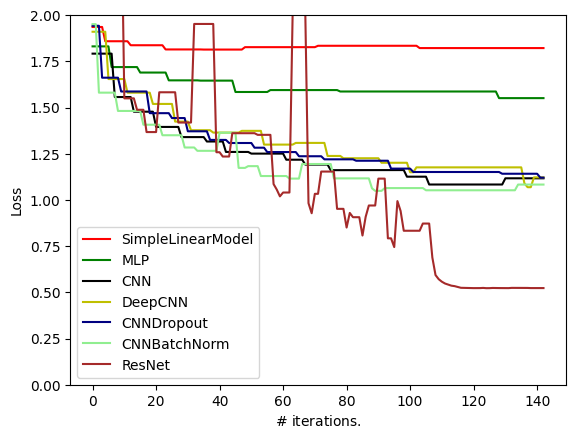

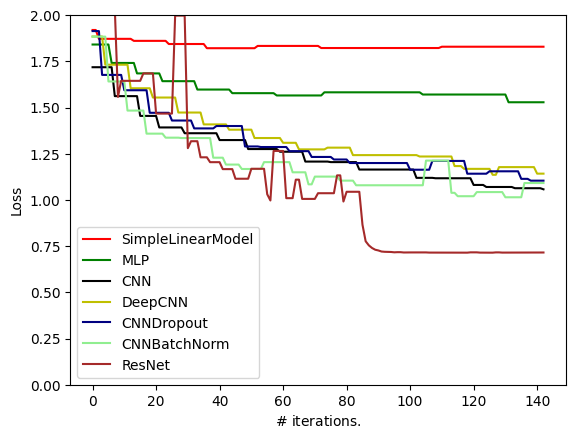

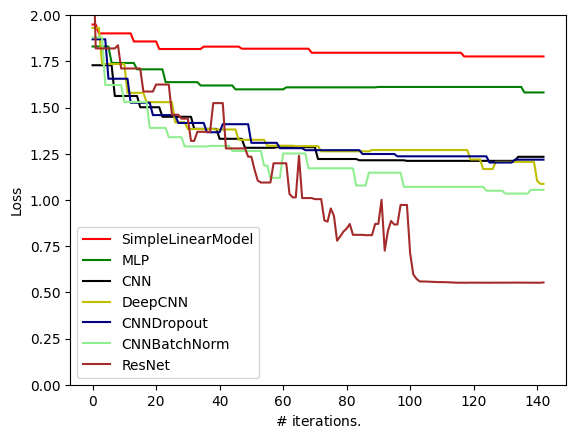

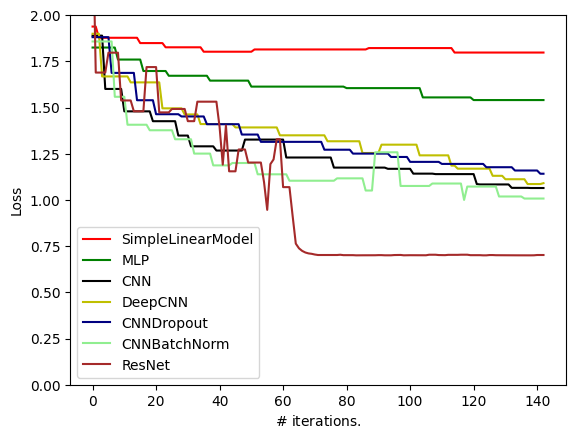

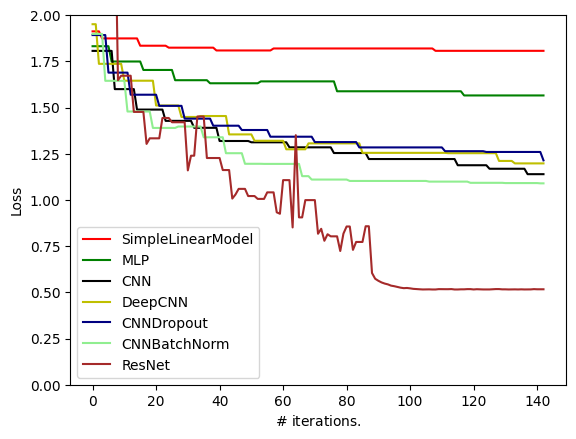

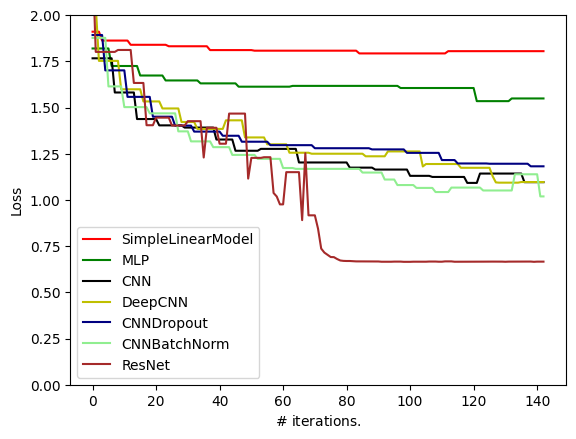

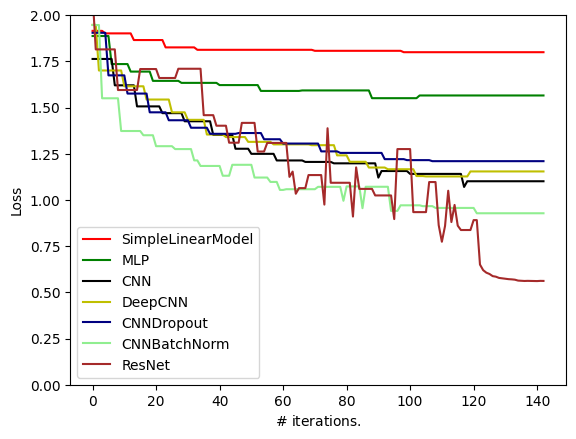

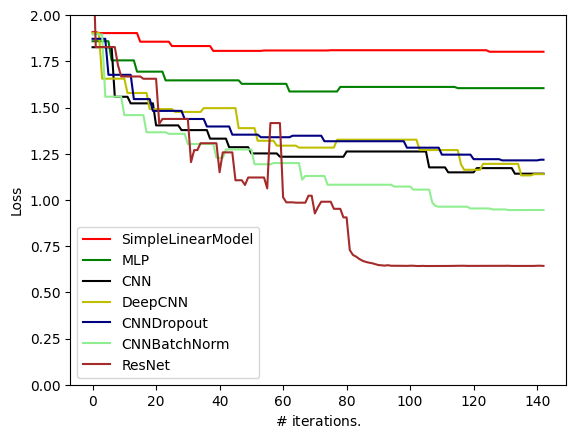

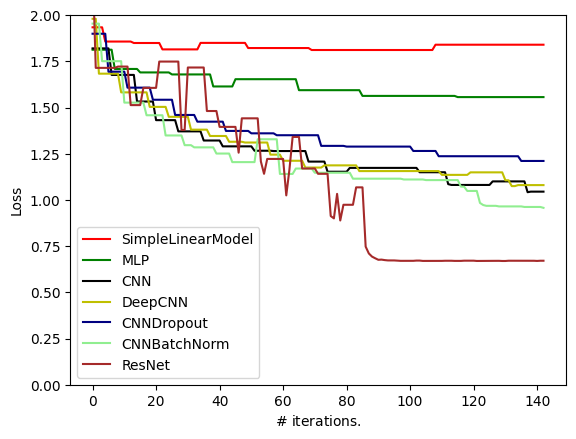

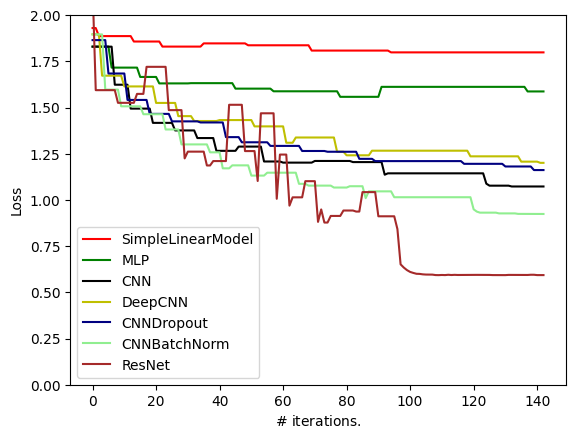

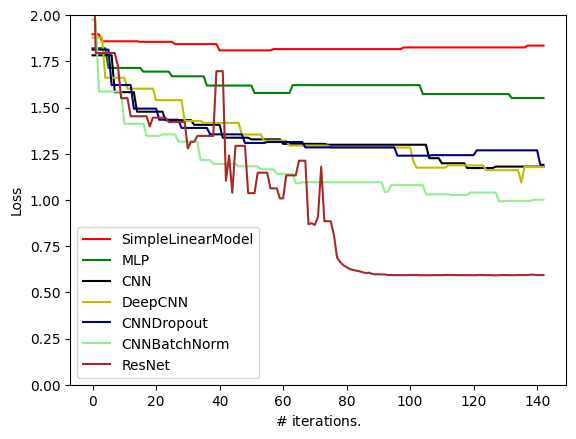

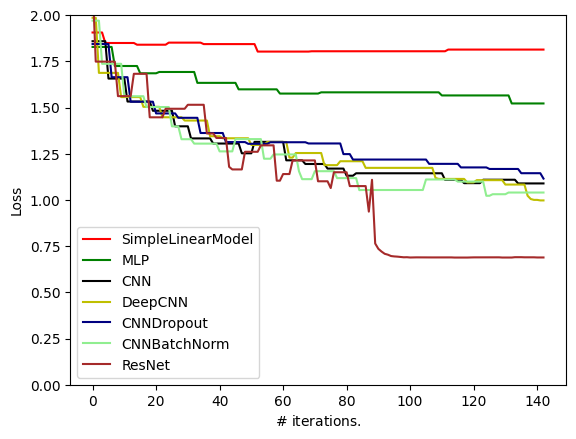

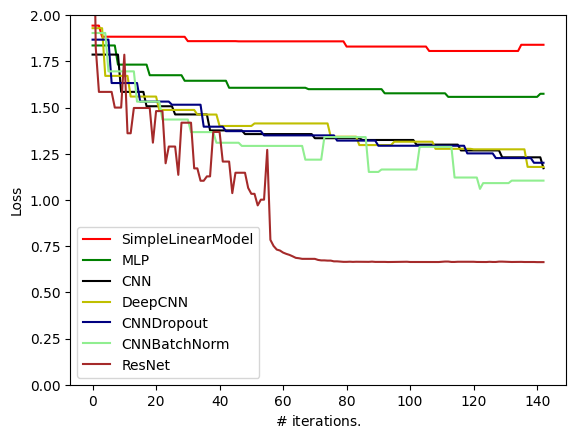

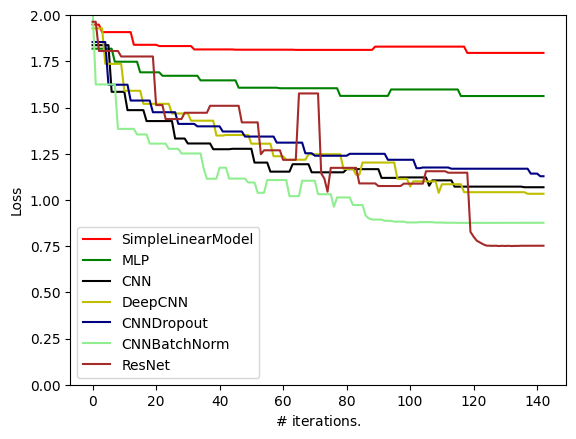

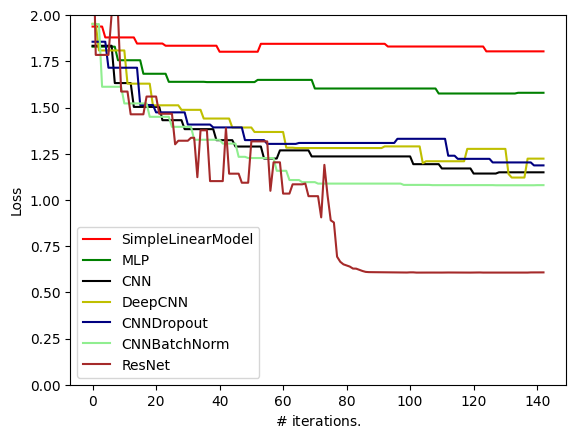

In [9]:
import numpy as np
run_loss_hist = []
for run_id in exps['run_id']:
    artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="ucb_values.json")
    artifact_path
    with open(artifact_path, "r") as f:
            rf = json.load(f)

    duration, key_res = parse_values(rf)

    loss_hist = key_res['loss'].T
    run_loss_hist.append(loss_hist)
    bound_hist = key_res['ucb_val'].T

    import matplotlib.pyplot as plt

    colors = ["r", "g", "black", 'y', "navy", 'lightgreen', "brown", "blue", "purple"]
    model_names = [elem[0] for elem in list(tab.values())[1]]
    for i, (loss, bound, color, m_name) in enumerate(zip(loss_hist, bound_hist, colors, model_names)):
        plt.plot(loss, label = m_name, color = color)
        x = np.arange(len(loss))
        # plt.fill_between(x, bound, loss,color=color,
        #                 alpha=0.1,)
    plt.ylim((0, 2,))
    plt.xlabel(r"$\#$ iterations.")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

delta graph

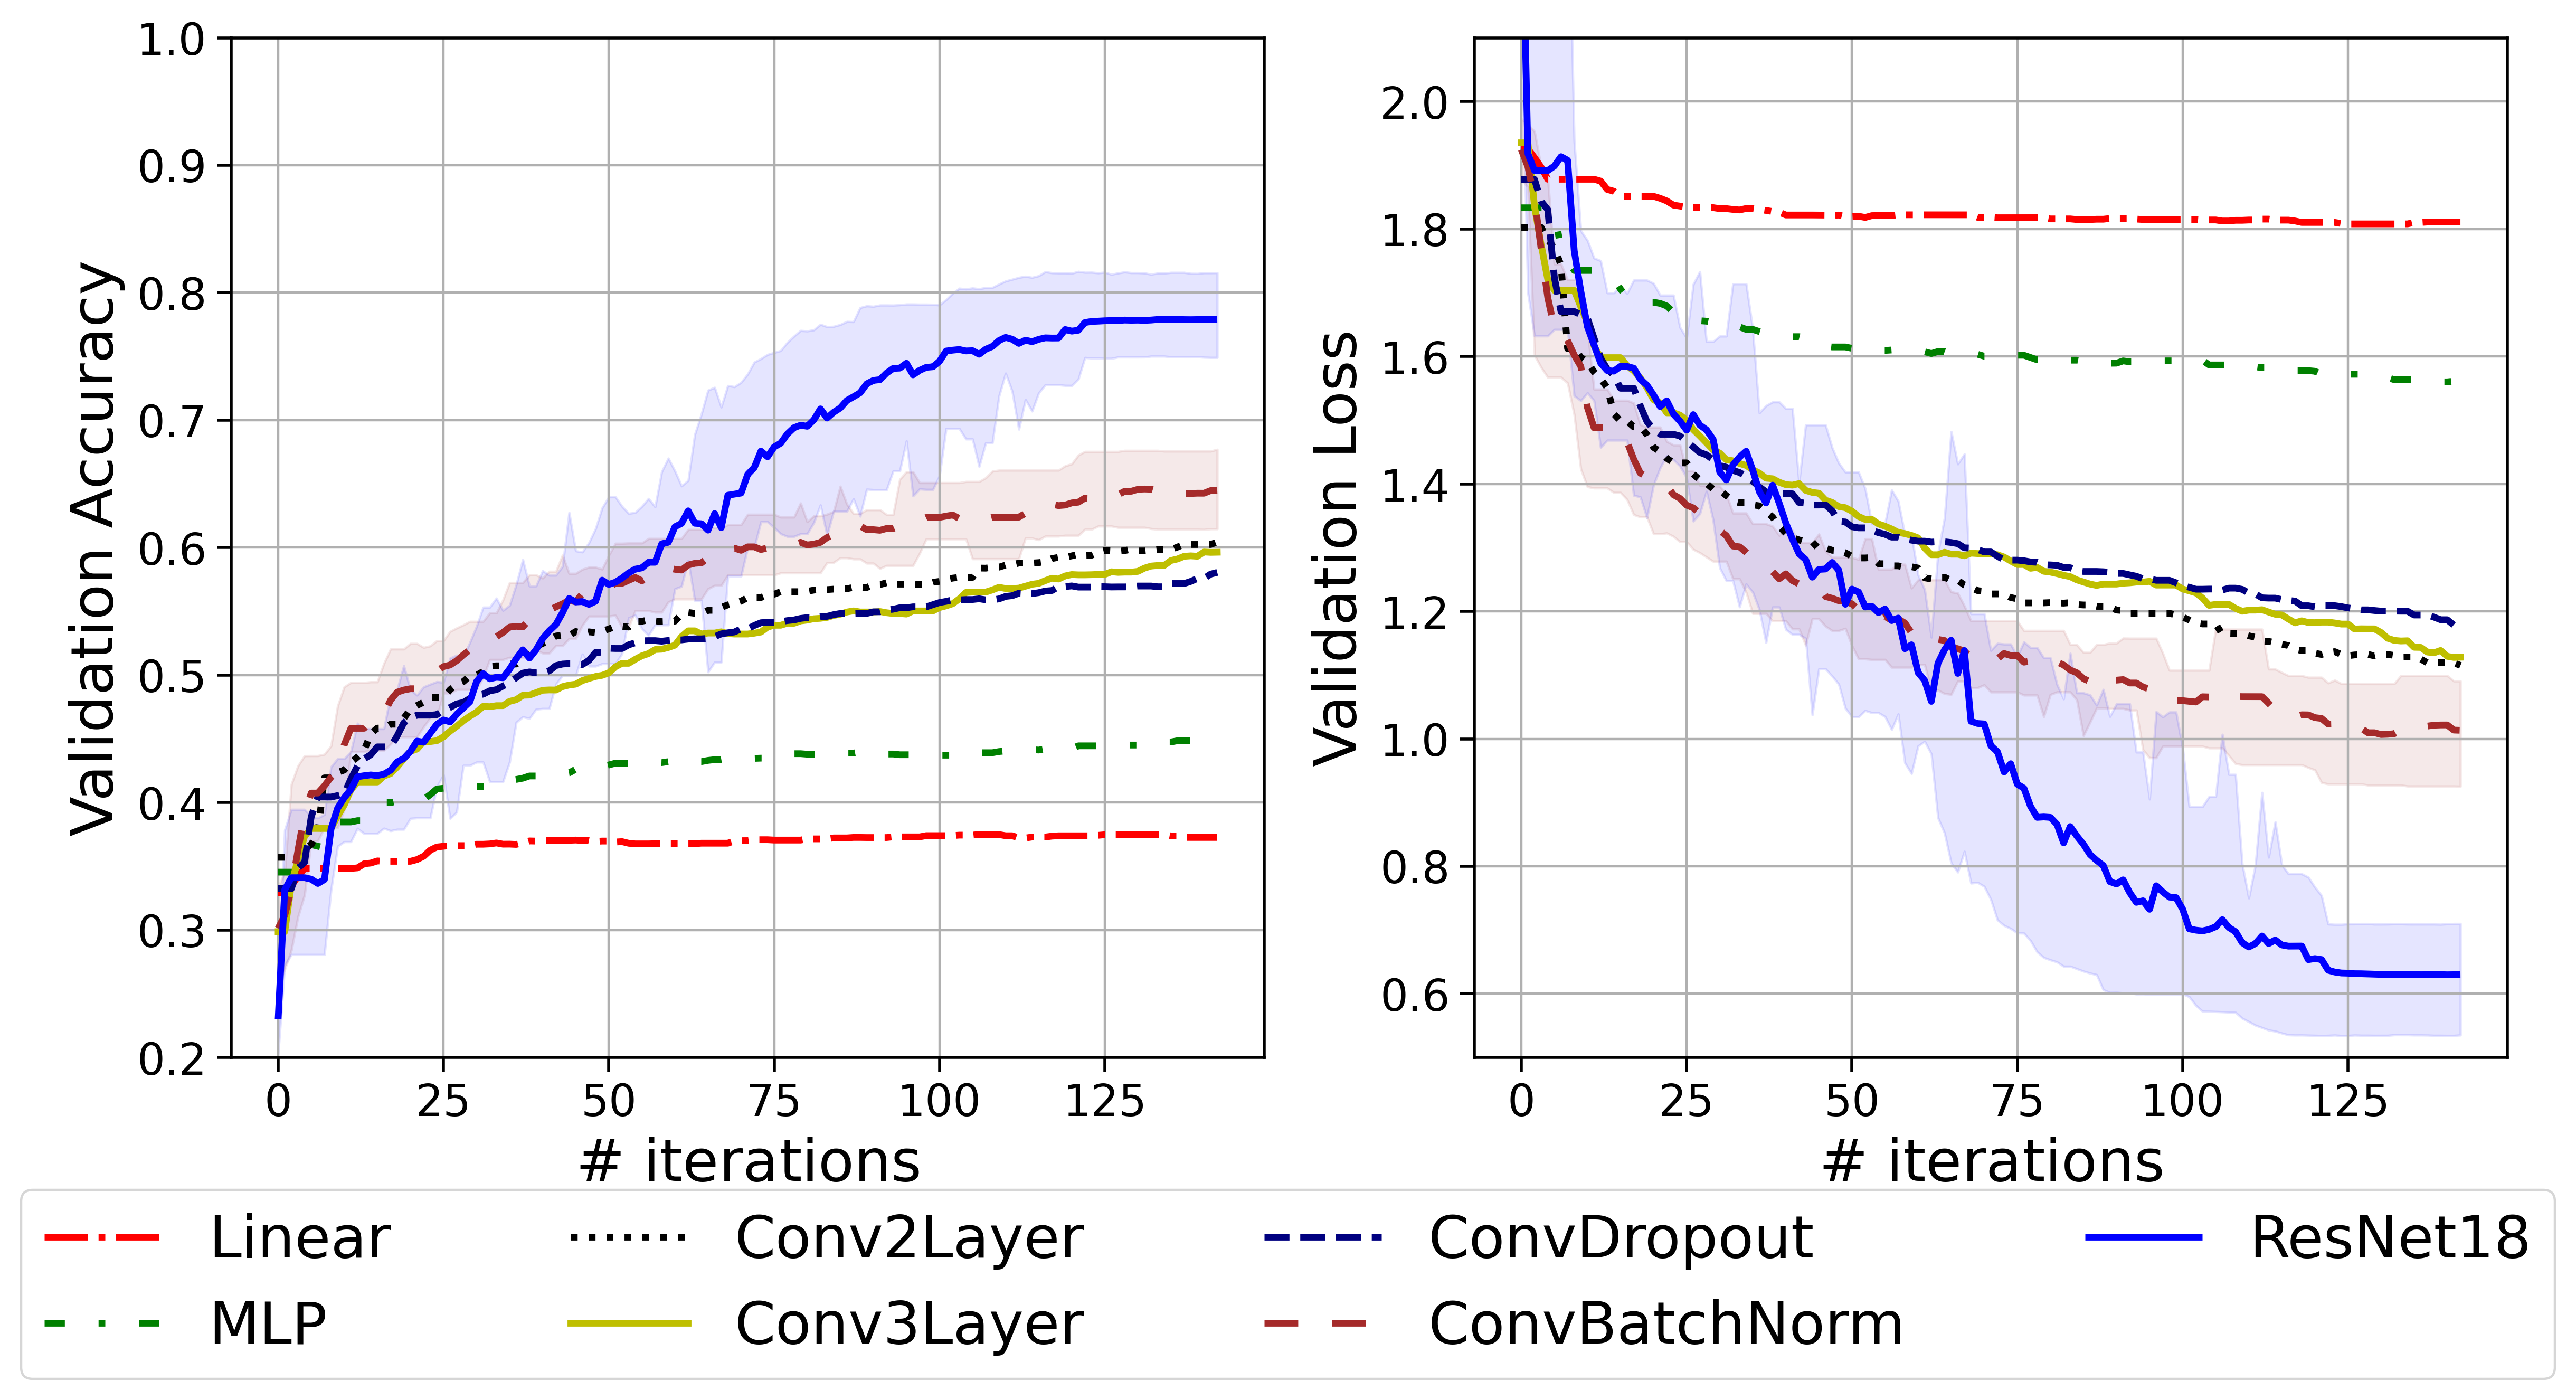

In [79]:
from multiobjective_opt.utils import LINESTYLES

import matplotlib.pyplot as plt

import numpy as np
def get_loss_hist(key = "loss"):
    run_loss_hist = []
    for run_id in exps['run_id']:
        artifact_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="ucb_values.json")
        artifact_path
        with open(artifact_path, "r") as f:
                rf = json.load(f)

        # for i in range(7):
        #     rf[i] = {"arm": rf[i][0],"duration": rf[i][1], "pull_res": rf[i][2]}

        duration, key_res = parse_values(rf)

        loss_hist = key_res[key].T
        run_loss_hist.append(loss_hist)
    return run_loss_hist




from multiobjective_opt.utils import LINESTYLES, get_fig_set_style
def plot_vals(ax, run_hist, ylabel, ylim):
    losses = np.stack(run_hist)
    mean_loss = losses.mean(0)
    low_loss = np.quantile(losses, 0.1, 0)
    high_loss = np.quantile(losses, 0.9, 0)


    colors = ["r", "g", "black", 'y', "navy",  "brown", "blue", "purple", 'darkgreen',]
    model_names = [elem[0] for elem in list(tab.values())[1]]
    model_names = ["Linear", "MLP", "Conv2Layer", "Conv3Layer", "ConvDropout", "ConvBatchNorm", "ResNet18"]
    for i, (loss, low, high, color, m_name, ls) in enumerate(zip(mean_loss, low_loss, high_loss, colors, model_names, LINESTYLES)):
        # plt.fill_between(x, loss - std,loss + std , color=color, alpha=0.1,)
        if m_name == "ResNet":
            m_name = "ResNet18"
        ax.plot(loss, label = m_name, color = color, linestyle=ls[1])
        x = np.arange(len(loss))
        if m_name in ["ResNet18", "ConvBatchNorm"]:
            ax.fill_between(x, low, high, color=color, alpha=0.1,)

    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r"$\#$ iterations")
    ax.grid()
    # ax.legend()

fig, ax, _ = get_fig_set_style(7, shape=(1,2), figsize=(12,6))
ax[1].grid()
plot_vals(ax[0], get_loss_hist("accuracy"), "Validation Accuracy", (0.2, 1.))
plot_vals(ax[1], get_loss_hist("loss"), "Validation Loss", (0.5, 2.1))
h, legend_ = ax[0].get_legend_handles_labels()

fig.legend(
    h[:],
    legend_[:],
    ncol=4,
    bbox_to_anchor=(0.0, -0.06, 1, 0.10),
    loc="outside upper left",
    mode="expand",
    borderaxespad=0,
)

fig.tight_layout()
# fig = fig.subplots_adjust(bottom=0.1)
figs = {"both": fig}
# ax.grid()


# figs = {}
# figs["acc"] = plot_vals(get_loss_hist("accuracy"), "Accuracy", (0.2, 1.))
# figs["loss"] = plot_vals(get_loss_hist("loss"), "Loss", (0.5, 2.1))

In [80]:
import os
from pathlib import Path
from multiobjective_opt.utils import savefig
savepath = Path("./exp_results/figures/cv")
# exp_results/figures
for f_name, fig in figs.items():
    path = savepath
    if not path.exists():
        os.mkdir(path)
    f_name = f"{f_name}"
    savefig(fig, path, f_name, bbox_inches="tight")

### тренировка до точности в 1 процент

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

In [24]:
from itsdangerous import TimestampSigner
import mlflow
from mlflow.tracking import MlflowClient

# Инициализация клиента MLflow
client = MlflowClient()

# Название родительского эксперимента и запуска
experiment_name = "cifar10_simple_min_log_fixed"
parent_run_name = "full_train:08:08"
# parent_run_name = "full_train:10:51"

# Шаг 1: Найти родительский запуск
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Эксперимент '{experiment_name}' не найден.")

# Поиск родительского запуска по имени
parent_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{parent_run_name}'"
)

if not parent_runs:
    raise ValueError(f"Родительский запуск '{parent_run_name}' не найден.")

parent_run = parent_runs[0]
parent_run_id = parent_run.info.run_id

# Шаг 2: Найти все дочерние запуски
child_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'"
)

# Шаг 3: Обработка результатов дочерних запусков

def get_loss(key):
    losses = []
    timestamps = []
    alg_names = []
    for run in child_runs:
        run_id = run.info.run_id
        run_name = run.data.tags.get("mlflow.runName", "Unnamed Run")
        values = client.get_metric_history(run_id=run.info.run_id, key=key)
        loss = [l.value for l in values]
        times = [l.timestamp for l in values]
        
        losses.append(loss)
        timestamps.append(times)
        alg_names.append(run_name)
        # losses[run_name] = loss
        # timestamps[run_name] = times
    return losses, timestamps, alg_names

losses, timestamps, alg_names = get_loss("accuracy")


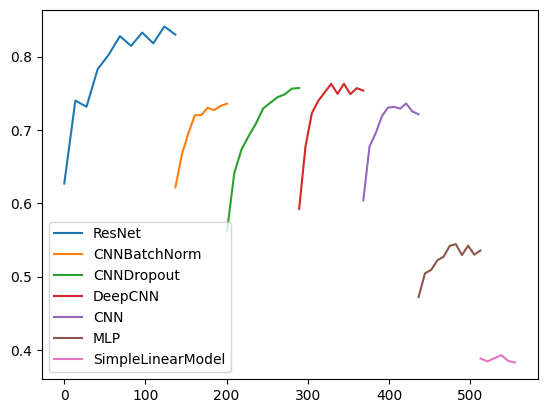

In [25]:
t_start = 0
times = []
fig, ax = plt.subplots()
for i, (l, t, n) in enumerate(zip(losses, timestamps, alg_names)):
    x = np.array(t) -t[0] + t_start
    t_start = x[-1]
    x = x/1000
    times.append(x)
    ax.plot(x, l,label = n)
ax.legend()

In [26]:
times = np.concat(times)


In [27]:
times[-1]

np.float64(555.484)

In [39]:
from itsdangerous import TimestampSigner
import mlflow
from mlflow.tracking import MlflowClient


def get_duration(timestamps):
    t_start = 0
    t_end = 0
    for t in timestamps:
        x = np.array(t) -t[0] + t_start
        t_start = x[-1]
        x = x/1000
        t_end = x[-1]
    return t_end

def get_loss(key, child_runs):
    # losses = []
    timestamps = []
    # alg_names = []
    for run in child_runs:
        run_id = run.info.run_id
        run_name = run.data.tags.get("mlflow.runName", "Unnamed Run")
        values = client.get_metric_history(run_id=run.info.run_id, key=key)
        loss = [l.value for l in values]
        times = [l.timestamp for l in values]
        
        losses.append(loss)
        timestamps.append(times)
        alg_names.append(run_name)
        # losses[run_name] = loss
        # timestamps[run_name] = times
    return get_duration(timestamps)


# Инициализация клиента MLflow
client = MlflowClient()

# Название родительского эксперимента и запуска
experiment_name = "cifar10_simple_min_log_fixed"
parent_run_name_st = "full_train"

# Шаг 1: Найти родительский запуск
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    raise ValueError(f"Эксперимент '{experiment_name}' не найден.")

# Поиск родительского запуска по имени
parent_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName LIKE '{parent_run_name_st}%'"
)

if not parent_runs:
    raise ValueError(f"Родительский запуск '{parent_run_name}' не найден.")

runtimes = []
for parent_run in parent_runs:
    parent_run_id = parent_run.info.run_id

    # Шаг 2: Найти все дочерние запуски
    child_runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'"
    )


    runtimes.append(get_loss("accuracy", child_runs)/60)


In [ ]:
np.mean(runtimes), np.std(runtimes)

(np.float64(9.853473333333334), np.float64(0.3511333812100462))

In [63]:
from multiobjective_opt.neural_net.utils.dataset_prepare import CIFAR10Handler
handler = CIFAR10Handler()
tr, test = handler.load_dataset()

Files already downloaded and verified
Files already downloaded and verified


In [64]:
i = 0
for _ in tr.get_iterator():
    i += 1
i

391

## табличка с параметрами моделей

In [77]:
from multiobjective_opt.neural_net.models.cifar_models import (
    CNN,
    MLP,
    CNNBatchNorm,
    CNNDropout,
    DeepCNN,
    ResNet18,
    SimpleLinearModel,
)
model_names_new = ["Linear", "MLP", "Conv2Layer", "Conv3Layer", "ConvDropout", "ConvBatchNorm", "ResNet18"]
def get_models():
    models = {
        "Linear": SimpleLinearModel(),
        "MLP": MLP(),
        "Conv2Layer": CNN(),
        "Conv3Layer": DeepCNN(),
        "ConvDropout": CNNDropout(),
        "ConvBatchNorm": CNNBatchNorm(),
        "ResNet18": ResNet18(),
    }
    
    return models
models = get_models()


In [78]:
import torch
import torch.nn as nn
# from torchsummary import summary
from tabulate import tabulate

def analyze_model(model):
    # Словарь для хранения информации о модели
    model_info = {
        "Total Parameters": 0,
        "Conv Layers": 0,
        "Conv Parameters": 0,
        "Normalization Layers": 0,
        "Dropout Layers": 0,
    }

    # Перебор всех модулей модели
    for name, module in model.named_modules():
        # Подсчет общего числа параметров
        if isinstance(module, nn.Conv2d):
            model_info["Conv Layers"] += 1
            model_info["Conv Parameters"] += sum(p.numel() for p in module.parameters())
        elif isinstance(module, (nn.BatchNorm2d, nn.LayerNorm, nn.GroupNorm)):
            model_info["Normalization Layers"] += 1
        elif isinstance(module, nn.Dropout):
            model_info["Dropout Layers"] += 1

    # Подсчет общего числа параметров
    model_info["Total Parameters"] = sum(p.numel() for p in model.parameters())

    return model_info

def print_model_table(models):
    # Создание таблицы
    table = []
    headers = ["Model", "Total Parameters", "Conv Layers", "Conv Parameters", "Normalization Layers", "Dropout Layers"]

    for name, model in models.items():
        info = analyze_model(model)
        table.append([name, info["Total Parameters"], info["Conv Layers"], info["Conv Parameters"], info["Normalization Layers"], info["Dropout Layers"]])

    # Вывод таблицы
    print(tabulate(table, headers=headers, tablefmt="latex_booktabs"))

# Пример использования
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 28 * 28, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# # Создание моделей
# model1 = SimpleCNN()
# model2 = SimpleCNN()  # Вторая модель для примера

# Анализ и вывод таблицы
# models = {"Model 1": model1, "Model 2": model2}
print_model_table(models, )


\begin{tabular}{lrrrrr}
\toprule
 Model         &   Total Parameters &   Conv Layers &   Conv Parameters &   Normalization Layers &   Dropout Layers \\
\midrule
 Linear        &              30730 &             0 &                 0 &                      0 &                0 \\
 MLP           &            1707274 &             0 &                 0 &                      0 &                0 \\
 Conv2Layer    &            2122186 &             2 &             19392 &                      0 &                0 \\
 Conv3Layer    &            1147466 &             3 &             93248 &                      0 &                0 \\
 ConvDropout   &            2122186 &             2 &             19392 &                      0 &                1 \\
 ConvBatchNorm &            2122378 &             2 &             19392 &                      2 &                0 \\
 ResNet18      &           11173962 &            20 &          11159232 &                     20 &                0 \\
\botto

In [73]:
import torchvision
model = torchvision.models.resnet18()
dct = {"n": model}
print_model_table(dct, )

\begin{tabular}{lrrrrr}
\toprule
 Model   &   Total Parameters &   Conv Layers &   Conv Parameters &   Normalization Layers &   Dropout Layers \\
\midrule
 n       &           11689512 &            20 &          11166912 &                     20 &                0 \\
\bottomrule
\end{tabular}
